## Data Analysis 3: Prediction and Introduction to Machine Learning - Assignment 2

In this study, our business question is what are the determinants of nightly prices apartments listed on Airbnb. By discovering these determinants, we will be able to help a company that is going to price their new apartments in Istanbul. We are going to use a cross sectional data to answer this question. Our data source is Inside Airbnb. The dataset has various columns including nightly prices, property type, room type, location etc. In the next chapters of this notebook, we will go through Sample Design, Explaratory Data Analysis, Feature Engineering and finally applying different Machine Learning Models.

### Sample Design

In this part, we get the data to be used for our analysis, apply necessary filters and prepare data for Exploratory Data Analysis.

In [1]:
# Import necessary packages

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

##### Get Data

In [2]:
# Import the prewritten helper functions
from py_helper_functions import *

In [3]:
# Import the data from Github
data = pd.read_csv('https://raw.githubusercontent.com/kocakale/hello-world/master/airbnb_detailed_listings_istanbul.csv')

In [4]:
# We have 37992 rows in raw data
data.shape

(37992, 75)

### Exploratory Data Analysis (EDA)

In this part we deal with missing values, check extreme values. First of all, we would like to know what does each column represent. In other words, we will shortly introduce the data in certain columns.

- `host_response_rate`: the response rate of the host
- `host_acceptance_rate`: number of requests to the host that convert to rentals
- `accommodates`: the number of guests the rental can accommodate
- `room_type`: the type of living space (Private room, Shared room, or Entire home/apt)
- `bedrooms`: number of bedrooms included in the rental
- `bathrooms`: number of bathrooms included in the rental
- `beds`: number of beds included in the rental
- `price`: nightly price for the rental
- `minimum_nights`: minimum number of nights a guest can stay
- `maximum_nights`: maximum number of nights a guest can stay
- `number_of_reviews`: number of reviews that previous guests have left

In [5]:
# We have many rows in the data that have NA values
data.isna().sum().sum()

514657

Since there are NA values, we have to clean or impute these values.

In [6]:
def calculate_na_percentage(df):
    # Find NA values in each column
    na_counts = df.isna().sum()
    
    # Exclude columns with zero NA values
    non_zero_na_columns = na_counts[na_counts > 0].index
    na_counts = na_counts[non_zero_na_columns]

    # Calculate percentage of NAs in each column
    na_percentage = (na_counts / len(df)) * 100

    # Create a DataFrame to display results
    result_df = pd.DataFrame({
        'Column': na_counts.index,
        'NA Count': na_counts.values,
        'NA Percentage': na_percentage.values
    })

    return result_df

result = calculate_na_percentage(data)
print(result)


                          Column  NA Count  NA Percentage
0                    description     37992     100.000000
1          neighborhood_overview     24330      64.039798
2                  host_location     13033      34.304590
3                     host_about     22770      59.933670
4             host_response_time      6061      15.953359
5             host_response_rate      6061      15.953359
6           host_acceptance_rate      6462      17.008844
7              host_is_superhost        54       0.142135
8             host_neighbourhood     33415      87.952727
9                  neighbourhood     24330      64.039798
10  neighbourhood_group_cleansed     37992     100.000000
11                     bathrooms     37992     100.000000
12                bathrooms_text        52       0.136871
13                      bedrooms     37992     100.000000
14                          beds       751       1.976732
15                         price       833       2.192567
16            

We have 75 columns. Some of the columns are empty and many of them have considerable amount of missing values. And some of columns that need to be numeric are object-type. We need to clean and transform data before applying any model.

In [7]:
# Calculate the percentage of missing values in each column
missing_percentage = (data.isna().sum() / len(data)) * 100

# Identify columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index

# Drop columns with more than 50% missing values
data = data.drop(columns=columns_to_drop)

In [8]:
# We removed 10 columns that have more than 50% missing values
data.shape

(37992, 65)

In [9]:
# Remove rows with any NA values
data = data.dropna()

In [10]:
data.shape

(15233, 65)

In [11]:
# Now we have 15.233 rows and 65 columns without any NAs
data.isna().sum().sum()

0

Removing rows with NA values shoul be carried out carrefully. If the missing values are not random, we might be loosing some pattern in the data. It may lead us to use a biased sample selection. Since further exploration is beyond this study, we will simply drop all rows with NA values and drop columns that have more than 50% missing values.

In [12]:
# After removing NA values, we need to filter data on number of accommodates that can accommodate on a listing
data.accommodates.unique()

array([ 3,  4,  1,  6,  2,  7,  5,  8,  9, 10, 12, 11, 13, 16, 14, 15],
      dtype=int64)

In [13]:
# We focus on apartments that can host 2-6 guests
data = data[(data['accommodates'] >= 2) & (data['accommodates'] <= 6)]

In [14]:
#Check shape of data after filter on number of 'accommodates'
data.shape

(13182, 65)

***Explore some selected variables***

In [15]:
# Summary statistics for numeric variables in raw data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,13182.0,5.333242e+17,4.071889e+17,3.417700e+04,4.843801e+07,7.066793e+17,8.904785e+17,1.054471e+18
scrape_id,13182.0,2.023123e+13,3.894679e+00,2.023123e+13,2.023123e+13,2.023123e+13,2.023123e+13,2.023123e+13
host_id,13182.0,2.422875e+08,1.834927e+08,7.883800e+04,4.648350e+07,2.289314e+08,4.243197e+08,5.500382e+08
host_listings_count,13182.0,2.813503e+01,8.272907e+01,1.000000e+00,2.000000e+00,6.000000e+00,1.400000e+01,4.660000e+02
host_total_listings_count,13182.0,3.689683e+01,1.150646e+02,1.000000e+00,3.000000e+00,8.000000e+00,1.700000e+01,7.120000e+02
latitude,13182.0,4.102780e+01,4.523376e-02,4.081536e+01,4.100530e+01,4.103147e+01,4.104598e+01,4.147988e+01
longitude,13182.0,2.898017e+01,1.232911e-01,2.806274e+01,2.897256e+01,2.898193e+01,2.901028e+01,2.989056e+01
accommodates,13182.0,3.341147e+00,1.280566e+00,2.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,6.000000e+00
beds,13182.0,1.918298e+00,1.205562e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,5.400000e+01
minimum_nights,13182.0,6.476787e+00,2.594874e+01,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,9.990000e+02


In [16]:
# Price column will be our target column to predict 
# It is not numeric in original data
# Remove dollar sign and commas, then convert to float
data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)
data.price.describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).map('{:,.1f}'.format)

count     13,182.0
mean       2,294.2
std        5,803.4
min          197.0
1%           400.0
10%          848.1
25%        1,216.0
50%        1,797.0
75%        2,642.8
90%        3,888.0
99%        9,198.0
max      600,000.0
Name: price, dtype: object

The range of prices is quite wide. The maksimum value of 600K might not be a nightly price. The `mean` is `2,294 USD` and `median` is `1,797 USD`. We will handle extreme values before applying forecasting models.

In [17]:
# These rate columns are object-type in raw data and I converted to float-type
# Remove '%' symbol and convert to float for 'host_response_rate' column
data['host_response_rate'] = data['host_response_rate'].str.rstrip('%').astype(float)

# Remove '%' symbol and convert to float for 'host_acceptance_rate' column
data['host_acceptance_rate'] = data['host_acceptance_rate'].str.rstrip('%').astype(float)

In [18]:
# Number of reviews
data.number_of_reviews.value_counts().sort_index()

number_of_reviews
1       1741
2       1122
3        848
4        705
5        537
        ... 
457        1
473        1
507        1
705        1
1248       1
Name: count, Length: 300, dtype: int64

The accomodation with the heighst review number has 1248 reviews.

In [19]:
# Although 'amenities' column looks like non-emty, it has empty lists. We will not be able to use this column
data.amenities.unique()

array(['[]'], dtype=object)

In [20]:
# Room type
data.room_type.value_counts()

room_type
Entire home/apt    10799
Private room        2219
Hotel room           137
Shared room           27
Name: count, dtype: int64

In [21]:
# I decided to remove the rows where `room_type` column has 'Hotel room', since we focus on apartments
data = data[data['room_type'] != 'Hotel room']

In [22]:
# Property type
data.property_type.value_counts()

property_type
Entire rental unit             8041
Private room in rental unit     880
Entire serviced apartment       807
Entire condo                    779
Entire home                     562
                               ... 
Barn                              1
Room in heritage hotel            1
Boat                              1
Island                            1
Shared room in guesthouse         1
Name: count, Length: 64, dtype: int64

In [23]:
# I decided to remove the rows where `property_type` column contains words hotel or hostel.
data = data[~data['property_type'].str.contains('hotel|hostel', case=False)]

In [24]:
# Since there are too many property types and most of them have only few observations, I decided to remove types that
# have less 10 observations
# Count occurrences of each property type
property_counts = data['property_type'].value_counts()

# Filter out property types with less than 10 occurrences
property_types_to_keep = property_counts[property_counts >= 10].index

# Filter the DataFrame to keep only rows with property types that have at least 10 occurrences
data = data[data['property_type'].isin(property_types_to_keep)]

In [25]:
# Check unique boroughs in Istanbul
data.neighbourhood_cleansed.value_counts()

neighbourhood_cleansed
Beyoglu          3683
Sisli            1628
Kadikoy          1355
Fatih            1177
Besiktas          802
Esenyurt          357
Uskudar           328
Kagithane         307
Bagcilar          257
Atasehir          213
Maltepe           163
Bahcelievler      155
Avcilar           112
Pendik            110
Sariyer           109
Adalar            105
Bakirkoy          101
Umraniye           88
Eyup               87
Basaksehir         87
Kartal             77
Sile               77
Zeytinburnu        73
Kucukcekmece       71
Beylikduzu         65
Arnavutkoy         46
Buyukcekmece       43
Beykoz             36
Gaziosmanpasa      28
Tuzla              27
Gungoren           22
Bayrampasa         20
Silivri            12
Cekmekoy           11
Esenler             9
Sultangazi          7
Catalca             5
Sancaktepe          4
Sultanbeyli         3
Name: count, dtype: int64

In [26]:
# We need to check the 'bathrooms_text' column as a potential explanatory variable ('bathrooms' column is empty)
data.bathrooms_text.unique()

array(['1 bath', '2 baths', '1.5 baths', '1.5 shared baths',
       '1 shared bath', '1 private bath', '2 shared baths', '2.5 baths',
       'Half-bath', '3 baths', '3.5 baths', '0 baths', '5 baths',
       '4 baths', '4 shared baths', 'Shared half-bath', '0 shared baths',
       '3 shared baths', '2.5 shared baths'], dtype=object)

In [27]:
# We need to convert the string values to numeric values to be able to use 
# Define a mapping dictionary
mapping = {
    '1 bath': 1,
    '1.5 baths': 1.5,
    '1 shared bath': 1,
    '2 baths': 2,
    '1.5 shared baths': 1.5,
    '1 private bath': 1,
    'Half-bath': 0.5,
    'Shared half-bath': 0.5,
    '3 baths': 3,
    '3.5 baths': 3.5,
    '0 baths': 0,
    '0 shared baths': 0,
    '2.5 baths': 2.5,
    '2.5 shared baths': 2.5,
    '2 shared baths': 2,
    '3 shared baths': 3,
    '4 baths': 4,
    '4 shared baths': 4,
    '5 baths': 5,
    
}

# Map the values in the 'bathroom_description' column to numeric values using the mapping dictionary
data['n_bathrooms'] = data['bathrooms_text'].map(mapping)

In [28]:
data.host_is_superhost.values

array(['t', 't', 't', ..., 'f', 't', 't'], dtype=object)

In [29]:
# Convert the 'host_is_superhost' to a dummy variable
data['host_is_superhost'] = data['host_is_superhost'].replace({'t': 1, 'f': 0})
data.host_is_superhost.unique()

array([1, 0], dtype=int64)

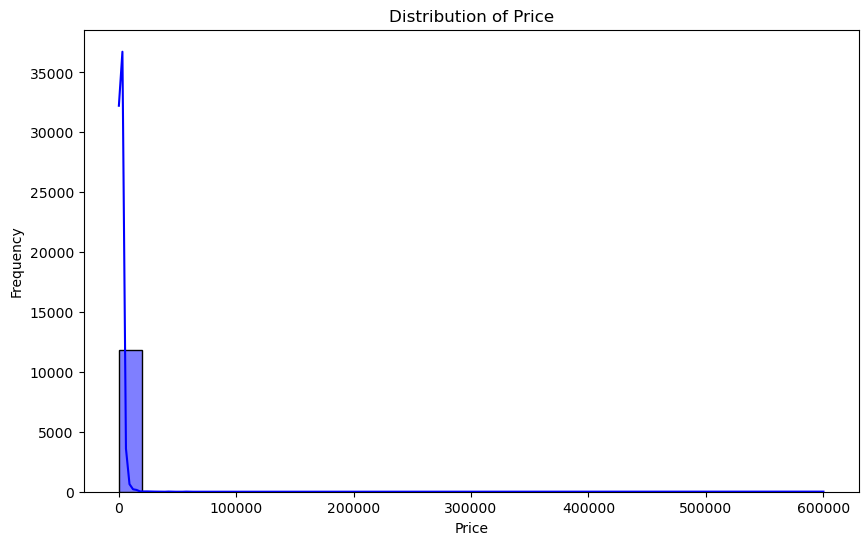

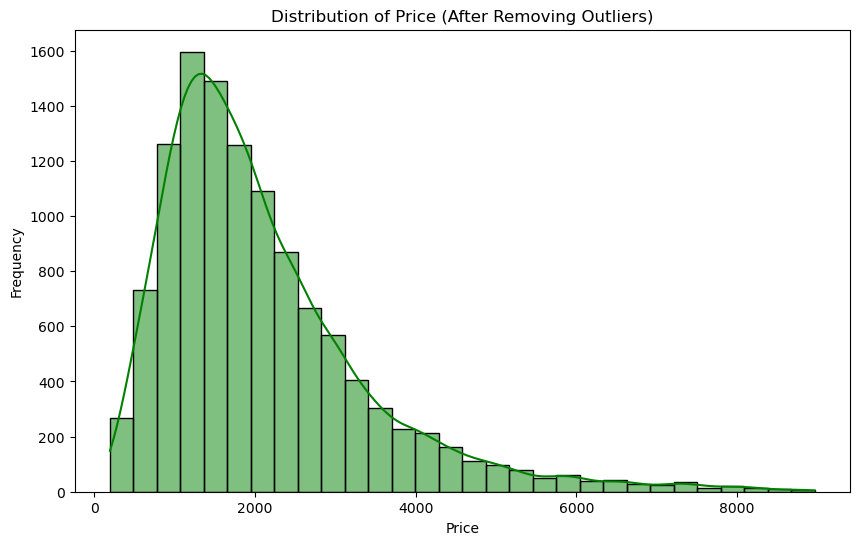

In [30]:
# Check for extreme values
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize distribution of 'price' column
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], kde=True, color='blue', bins=30)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Define threshold for outliers (e.g., 99th percentile)
threshold = data['price'].quantile(0.99)

# Remove outliers
data = data[data['price'] <= threshold]

# Visualize distribution of 'price' column after removing outliers
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], kde=True, color='green', bins=30)
plt.title('Distribution of Price (After Removing Outliers)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


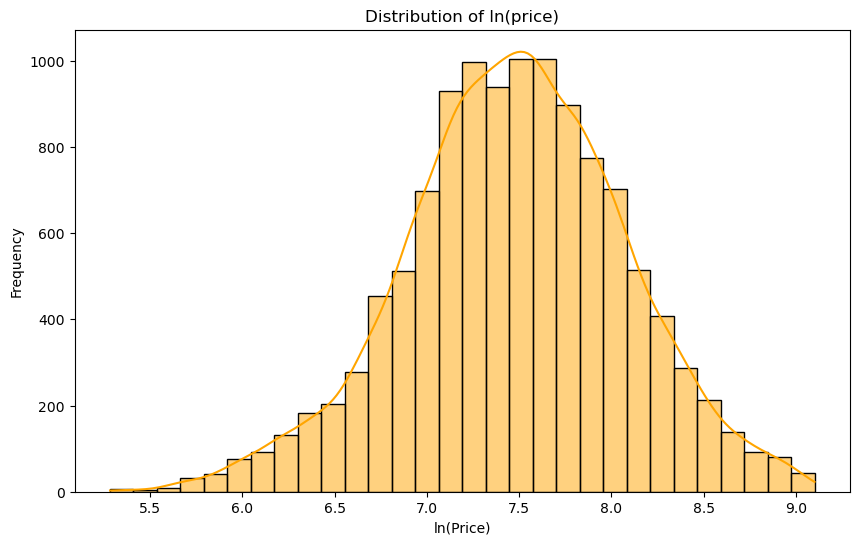

In [31]:
# Even after outlier/extreme value removal, the distribution of prices are right-skewed.
# I decided to use ln(price) observations which have more normal distribution

# Add a new column of ln(price)
data['ln_price'] = np.log(data['price'])

# Visualize distribution of ln(price) column
plt.figure(figsize=(10, 6))
sns.histplot(data['ln_price'], kde=True, color='orange', bins=30)
plt.title('Distribution of ln(price)')
plt.xlabel('ln(Price)')
plt.ylabel('Frequency')
plt.show()

### Feature Engineering

The most important task in this part is `variable selection`: what variables to have in the model
and in what functional forms, including potential interactions. Another step in this part to split the data as train and test datasets. We train a model on the train data and then test the performance of the model on the test data that we do not use in any step of model creation.

In [32]:
# Rename the columns to have a better understanding
# Define a mapping dictionary for renaming
mapping = {'host_response_time': 'f_host_response_time', 
           'host_response_rate': 'n_host_response_rate',
           'host_acceptance_rate': 'n_host_acceptance_rate', 
           'host_is_superhost': 'd_host_is_superhost',
           'neighbourhood_cleansed': 'f_neighbourhood_cleansed', 
           'property_type': 'f_property_type',
           'room_type': 'f_room_type', 
           'accommodates': 'n_accommodates', 
           'beds': 'n_beds', 
           'minimum_nights': 'n_minimum_nights', 
           'availability_365': 'n_availability_365',
           'number_of_reviews': 'n_number_of_reviews', 
           'review_scores_rating': 'n_review_scores_rating'}

# Rename columns using the mapping dictionary
data_final = data.rename(columns=mapping)

In [124]:
data_final.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'f_host_response_time', 'n_host_response_rate',
       'n_host_acceptance_rate', 'd_host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'f_neighbourhood_cleansed', 'latitude', 'longitude', 'f_property_type',
       'f_room_type', 'n_accommodates', 'bathrooms_text', 'n_beds',
       'amenities', 'price', 'n_minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'n_availability_365', 'calendar_last_scraped', 'n_number_of_rev

In [33]:
# Split the data into two sets, namely train and test/holdout
# Although the convention is to use 80/20 split, we use 70/30 split to work with a smaller train dataset
data_train, data_holdout = train_test_split(data_final, train_size=0.7, random_state=42)

In [34]:
data_train.shape, data_holdout.shape

((8218, 67), (3523, 67))

In [35]:
# We renamed the columns in data to be used in our analysis by adding f_, n_ and d_ prefixes
data_final.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'f_host_response_time', 'n_host_response_rate',
       'n_host_acceptance_rate', 'd_host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'f_neighbourhood_cleansed', 'latitude', 'longitude', 'f_property_type',
       'f_room_type', 'n_accommodates', 'bathrooms_text', 'n_beds',
       'amenities', 'price', 'n_minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'n_availability_365', 'calendar_last_scraped', 'n_number_of_rev

In [36]:
# We decided on the following group of variables to be used in ML models we will compare
basic_vars = [
    "n_accommodates",
    "n_beds",
    "f_property_type",
    "f_room_type",
    "n_bathrooms",
    "f_neighbourhood_cleansed",
    "n_availability_365", # column gives the number of days a listing is available out of 365 days
    "n_minimum_nights", # Minimum number of nights to book the place
    "f_host_response_time",
    "n_host_response_rate",
    "n_host_acceptance_rate",
]

# reviews
reviews = [
    "n_number_of_reviews",
    "n_review_scores_rating",
]

# dummy variables
super_host = ["d_host_is_superhost"]

# interactions for the LASSO
X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

In [37]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + super_host
predictors_E = basic_vars + reviews + super_host + X1 + X2

### Modelling

We start modelling with Random Forest model. We will explore in details the contribution of factors that determines the price of an accommodation Then we compare the overall performance of this model with Ordinary Least Square (`OLS`), `LASSO` and Gradient Boosting Machine (`GBM`).

##### Model1: Random Forest

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [38]:
# Create y-vector (dependant variable) and X-matrice (explanatory variables)
y, X = dmatrices("ln_price ~ " + " + ".join(predictors_2), data_train) # we created this to compare OLS with log(price)
y2, X22 = dmatrices("price ~ " + " + ".join(predictors_2), data_train) 

In [39]:
# X matrice is created in a way that every category in categorical variable is taken as a seperate column
X.shape

(8218, 76)

In [40]:
# a two-dimensional object
y.shape

(8218, 1)

In [41]:
# using ravel() we flatten it to a one-dimensional data object. 
y.ravel().shape

(8218,)

In [42]:
# Create the Random Forest Regressor of sklearn package
rfr = RandomForestRegressor(random_state = 20240129)

In [43]:
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

In [44]:
# Created one for level prices and one for log prices
# Find the best values for hyperparameters of a model

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


rf_random2 = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

`GridsearchCV()` is an exhaustive search over specified parameter values for an estimator.

In [45]:
%%time
rf_model = rf_random.fit(X, y.ravel())
rf_model2 = rf_random2.fit(X22, y2.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-0.460 total time=   0.8s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-0.475 total time=   0.8s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-0.454 total time=   0.8s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-0.469 total time=   0.8s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-0.459 total time=   0.8s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-0.473 total time=   0.6s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-0.487 total time=   0.7s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-0.469 total time=   0.6s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-0.480 total time=   0.6s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-0.475 total time=   0.6s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-0.479 total time=   0.6s
[CV 2/5] END max_features=6, mi

[CV 2/5] END max_features=10, min_samples_leaf=10;, score=-1140.338 total time=   1.7s
[CV 3/5] END max_features=10, min_samples_leaf=10;, score=-1086.463 total time=   1.6s
[CV 4/5] END max_features=10, min_samples_leaf=10;, score=-1090.417 total time=   2.1s
[CV 5/5] END max_features=10, min_samples_leaf=10;, score=-1064.439 total time=   2.3s
[CV 1/5] END max_features=10, min_samples_leaf=15;, score=-1094.791 total time=   2.1s
[CV 2/5] END max_features=10, min_samples_leaf=15;, score=-1154.678 total time=   1.9s
[CV 3/5] END max_features=10, min_samples_leaf=15;, score=-1097.906 total time=   1.9s
[CV 4/5] END max_features=10, min_samples_leaf=15;, score=-1101.011 total time=   1.3s
[CV 5/5] END max_features=10, min_samples_leaf=15;, score=-1074.466 total time=   1.1s
[CV 1/5] END max_features=12, min_samples_leaf=5;, score=-1054.841 total time=   2.6s
[CV 2/5] END max_features=12, min_samples_leaf=5;, score=-1114.515 total time=   1.7s
[CV 3/5] END max_features=12, min_samples_lea

<br>

Cross-validated results are saved in the grid search object's `cv_results_` attribute. *RMSE* is displayed as a negative number. 

In [46]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]
df_rf_model2_cv_results = pd.DataFrame(rf_model2.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

In [47]:
# Rename columns of the results of first random forest model (df_rf_model with ln(price))
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE_ln']

# Calculate mean price
mean_price_ln = np.mean(y)
mean_price_level = np.mean(y2)

# Calculate prediction error percentage
rmse_values_ln = -df_rf_model_cv_results['RMSE_ln']
df_rf_model_cv_results['RMSE_ln'] = rmse_values_ln
error_percentage_ln = (rmse_values_ln / mean_price_ln)

rmse_values_level = -df_rf_model2_cv_results['mean_test_score']
error_percentage_level = (rmse_values_level / mean_price_level)

# Add prediction error percentage to the DataFrame
df_rf_model_cv_results['RMSE_percentage_ln'] = error_percentage_ln

# Add RMSE of level price as y to the DataFrame
df_rf_model_cv_results['RMSE_level'] = rmse_values_level

# Add prediction error percentage of level price as y to the DataFrame
df_rf_model_cv_results['RMSE_percentage_level'] = error_percentage_level

In [48]:
df_rf_model_cv_results

,max features,min node size,RMSE_ln,RMSE_percentage_ln,RMSE_level,RMSE_percentage_level
0,6,5,0.463479,0.062034,1099.631051,0.524614
1,6,10,0.476894,0.063830,1125.741635,0.537071
2,6,15,0.484348,0.064827,1139.739740,0.543749
3,8,5,0.452446,0.060557,1082.084618,0.516243
4,8,10,0.465354,0.062285,1105.771394,0.527543
5,8,15,0.472312,0.063216,1114.363726,0.531643
6,10,5,0.447108,0.059843,1069.940128,0.510449
7,10,10,0.459301,0.061475,1092.762778,0.521337
8,10,15,0.464863,0.062219,1104.570262,0.526970
9,12,5,0.444084,0.059438,1063.275360,0.507269


RMSE for level prices for different models of Random Forest is between 1,063 and 1,139. And comparing these values to mean prices, we get approximately 50% error. For log transformed predictions, this raito is around 5-6%. Although, Random Forest is said to not sensitive to non-normality, the results are a bit confusing.

In [49]:
# The best Random Forest model has minimum 5 observations in a terminal node 
# with 12 number of features that are considered when splitting a node
print(-rf_model2.best_score_)
print(rf_model2.best_params_)

1063.2753596533155
{'max_features': 12, 'min_samples_leaf': 5}


In [50]:
rf_model2.best_estimator_

RandomForestRegressor(max_features=12, min_samples_leaf=5,
                      random_state=20240129)

We have used some different columns than London data in our analysis and found similar results. The best model hast 12 features and 5 leafs similar to London data. However, we found larger RMSE values and the reason is that we have higher average prices and wider range. 

We also applied $log(price)$ as dependant variable and compared the results with level-prices. Random forest finds the best model with same specifications but `RMSE/mean(price)` ratio is very different in case of log-transformed prices as `y-variable`.

**Model1 Diagnostics**

In [51]:
rf_model2.best_estimator_.feature_importances_

array([0.00000000e+00, 3.00404462e-03, 3.81315661e-05, 6.75331382e-04,
       4.92572827e-03, 1.27800844e-03, 0.00000000e+00, 1.09686269e-02,
       8.41334326e-03, 0.00000000e+00, 0.00000000e+00, 1.14016824e-04,
       6.84640659e-03, 1.44555938e-03, 0.00000000e+00, 3.09527434e-03,
       5.55626171e-05, 4.80247119e-02, 2.75520683e-04, 1.32936479e-05,
       9.18156951e-05, 3.02482458e-04, 0.00000000e+00, 7.63971400e-02,
       2.77326817e-05, 1.57192130e-04, 4.83166684e-04, 1.70357846e-03,
       2.99908035e-03, 1.02508074e-03, 2.28047612e-04, 3.40521238e-04,
       0.00000000e+00, 1.72410902e-02, 1.89778428e-04, 3.49862734e-04,
       2.48631418e-02, 3.16228971e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.50651392e-02, 6.08379596e-04, 7.58497195e-03,
       4.27311968e-04, 3.47942958e-05, 6.55443016e-03, 1.39394303e-03,
       7.22688278e-05, 1.12347420e-04, 1.13544143e-03, 5.60227246e-04,
       0.00000000e+00, 4.79001861e-03, 4.85462745e-03, 0.00000000e+00,
      

In [52]:
df_var_imp = pd.DataFrame(
    rf_model2.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [53]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,n_accommodates,17.7%,17.7%
1,n_bathrooms,8.9%,26.6%
2,n_availability_365,8.1%,34.7%
3,f_room_type[T.Private room],7.6%,42.4%
4,n_host_acceptance_rate,7.3%,49.7%
5,n_beds,6.5%,56.2%
6,n_review_scores_rating,6.1%,62.3%
7,n_number_of_reviews,5.9%,68.1%
8,n_minimum_nights,5.9%,74.0%
9,f_property_type[T.Private room in rental unit],4.8%,78.8%


In terms of individual importances, `number of accommodates` that can stay at the listing have highest importance.

In [54]:
# we only care for variables with an importance of more than 1%
cutoff = 0.01

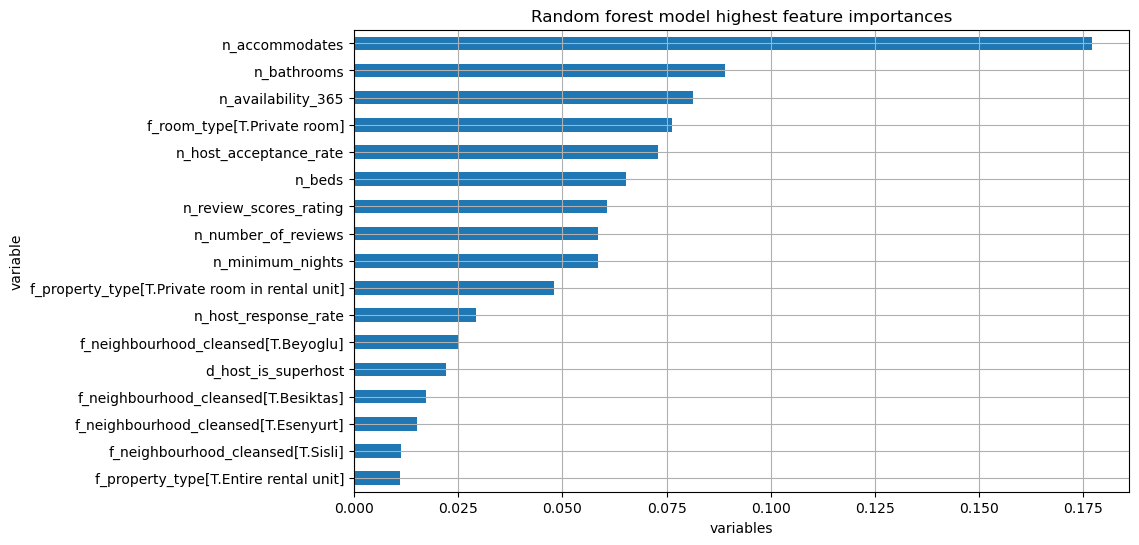

In [55]:
df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

Now we group variable importance. In other words, instead of looking at the individual categories of a categorical variable, we look at the total effect of the category.

In [56]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [57]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model2.best_estimator_)] # put best model to pipeline
)

rf_pipeline2 = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [58]:
%%time
rf_pipeline.fit(data_train[predictors_2],data_train.price)

CPU times: total: 5.58 s
Wall time: 5.66 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type',
                                                   'f_neighbourhood_cleansed',
                                                   'f_host_response_time']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_bathrooms',
                                                   'n_availability_365',
                                                   'n_minimum_nights',
                                                   'n_host_response_rate',
                                                   'n_host_acceptance_rate',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'd_host_is_superhost'])])),
                ('regressor',
                 RandomForestRegressor(max_features=12, min_samples_leaf=5,
                                       random_state=20240129))])

In [59]:
%%time
rf_pipeline2.fit(data_train[predictors_2],data_train.ln_price)

CPU times: total: 5.98 s
Wall time: 6.29 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type',
                                                   'f_neighbourhood_cleansed',
                                                   'f_host_response_time']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_bathrooms',
                                                   'n_availability_365',
                                                   'n_minimum_nights',
                                                   'n_host_response_rate',
                                                   'n_host_acceptance_rate',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'd_host_is_superhost'])])),
                ('regressor',
                 RandomForestRegressor(max_features=12, min_samples_leaf=5,
                                       random_state=20240129))])

In [60]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[predictors_2],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: total: 12.6 s
Wall time: 12.6 s


In [61]:
pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)

,0
n_accommodates,0.108039
n_beds,0.021519
f_property_type,0.031530
f_room_type,0.081053
n_bathrooms,0.070506
f_neighbourhood_cleansed,0.072460
n_availability_365,0.027792
n_minimum_nights,0.033756
f_host_response_time,0.005312
n_host_response_rate,0.009747


In [62]:
grouped = [
    "n_beds",
    "f_property_type",
    "f_room_type",
    "n_accommodates",
    "n_bathrooms",
    "f_neighbourhood_cleansed",
    "n_availability_365",
    "n_minimum_nights",
    "f_host_response_time",
    "n_host_response_rate",
    "n_host_acceptance_rate",
    "n_number_of_reviews",
    "n_review_scores_rating",
    "d_host_is_superhost"
]

In [63]:
df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

In [64]:
df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,n_accommodates,10.8%,10.8%
1,f_room_type,8.1%,18.9%
2,f_neighbourhood_cleansed,7.2%,26.2%
3,n_bathrooms,7.1%,33.2%
4,n_minimum_nights,3.4%,36.6%
5,n_host_acceptance_rate,3.3%,39.9%
6,f_property_type,3.2%,43.1%
7,n_availability_365,2.8%,45.8%
8,d_host_is_superhost,2.2%,48.1%
9,n_review_scores_rating,2.2%,50.3%


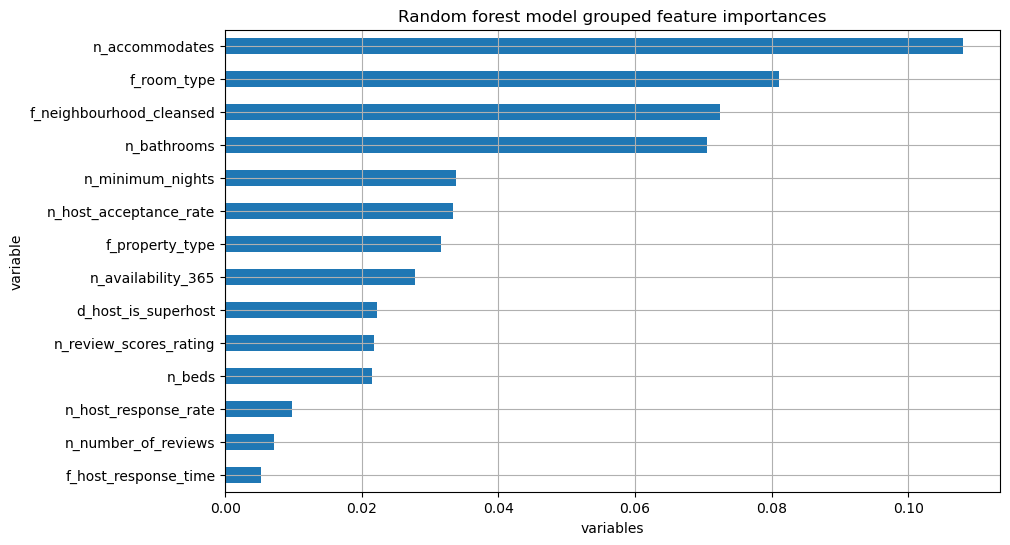

In [65]:
df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         );

In [66]:
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]

,variable,imp,cumulative_imp
0,n_accommodates,0.108039,0.177100
1,f_room_type,0.081053,0.266097
2,f_neighbourhood_cleansed,0.072460,0.347316
3,n_bathrooms,0.070506,0.423713
4,n_minimum_nights,0.033756,0.496751
5,n_host_acceptance_rate,0.033363,0.561890
6,f_property_type,0.031530,0.622585
7,n_availability_365,0.027792,0.681231
8,d_host_is_superhost,0.022283,0.739833
9,n_review_scores_rating,0.021767,0.787857


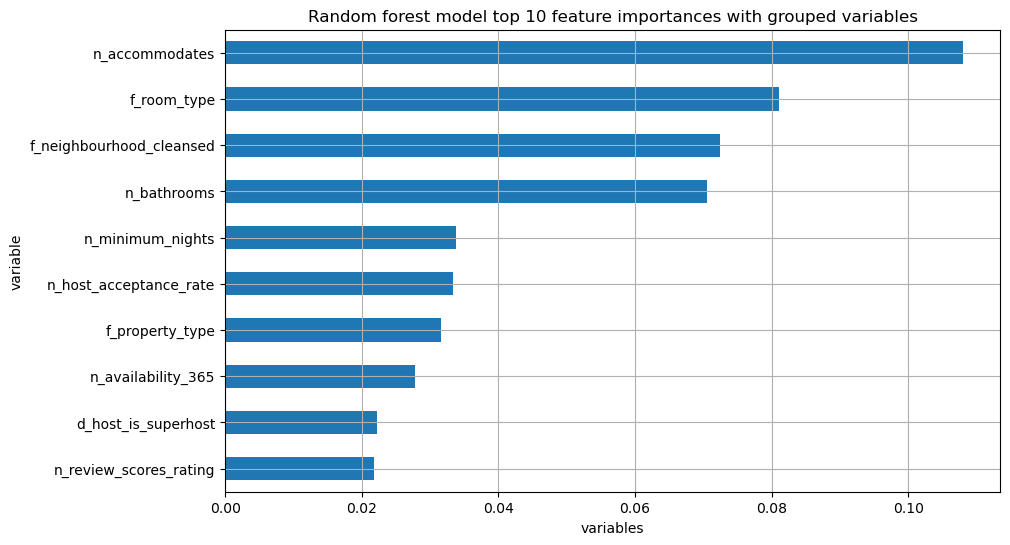

In [67]:
df_clean_varimp.iloc[0:10]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 10 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         );

Variable importances analysis show that, the most important factor (10.8%)for apartments in Istanbul is the number of `accomodates` that the apartment can host. `Room type` and `neighbourhood` are the 2nd and 3th important factors, respectively.

**Partial dependence plots** 

Partial dependence plots show the dependence between the target function and a set of features of interest, marginalizing over the values of all other features (the complement features). While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

In [68]:
# We check how number of accommodates (found to most important factor) affect prices
accomodates_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["n_accommodates"], kind="average"
)

In [69]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    )

,number of accomodates,average price
0,2,1847.720944
1,3,1945.110714
2,4,2193.856781
3,5,2446.939891
4,6,2584.463840


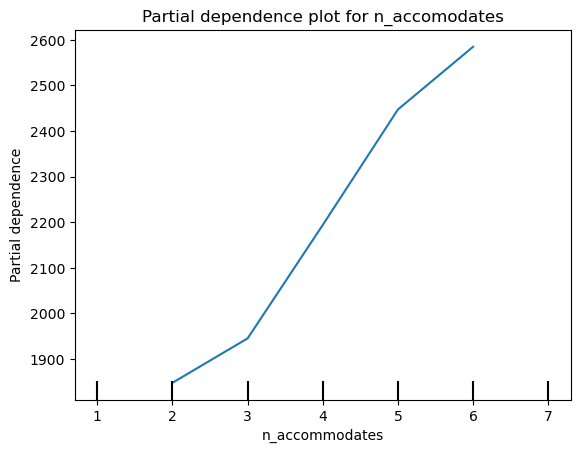

In [70]:
display = PartialDependenceDisplay(
    pd_results = [accomodates_pdp],
    features = [(0,)], 
    feature_names = data_holdout[predictors_2].columns.tolist(), 
    target_idx = 0,
    deciles = {0: np.linspace(1, 7, num=7)}
)
display.plot()
plt.title('Partial dependence plot for n_accomodates')
plt.show();

There is a clear effect in the expected direction of number of acoomodates on prices.

In [71]:
roomtype_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["f_room_type"], kind="average"
)

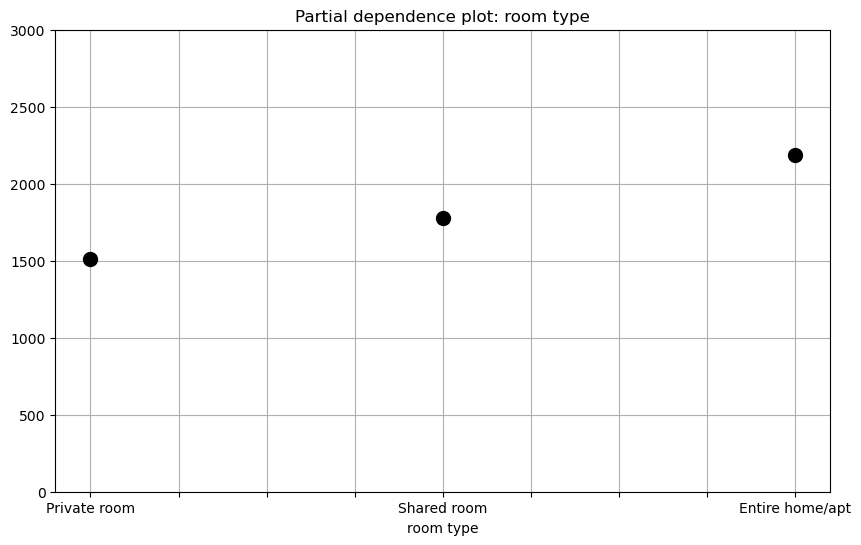

In [72]:
pd.DataFrame(
    {'room type': roomtype_pdp['values'][0], 
     'average price': roomtype_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'room type', y = 'average price', ylim = (0, 3000), 
    title = 'Partial dependence plot: room type'
);

Room type which is categorical variable found to be second most important factor that affect the prices. Private rooms seem cheaper than an entire home, which is expected.

**SHAP Importance**

Permutation importance and SHAP importance are alternative ways of measuring feature importance. The main difference is that permutation importance is based on the decrease in model performance, while SHAP importance is based on magnitude of feature attributions.

100%|===================| 2348/2349 [05:20<00:00]        

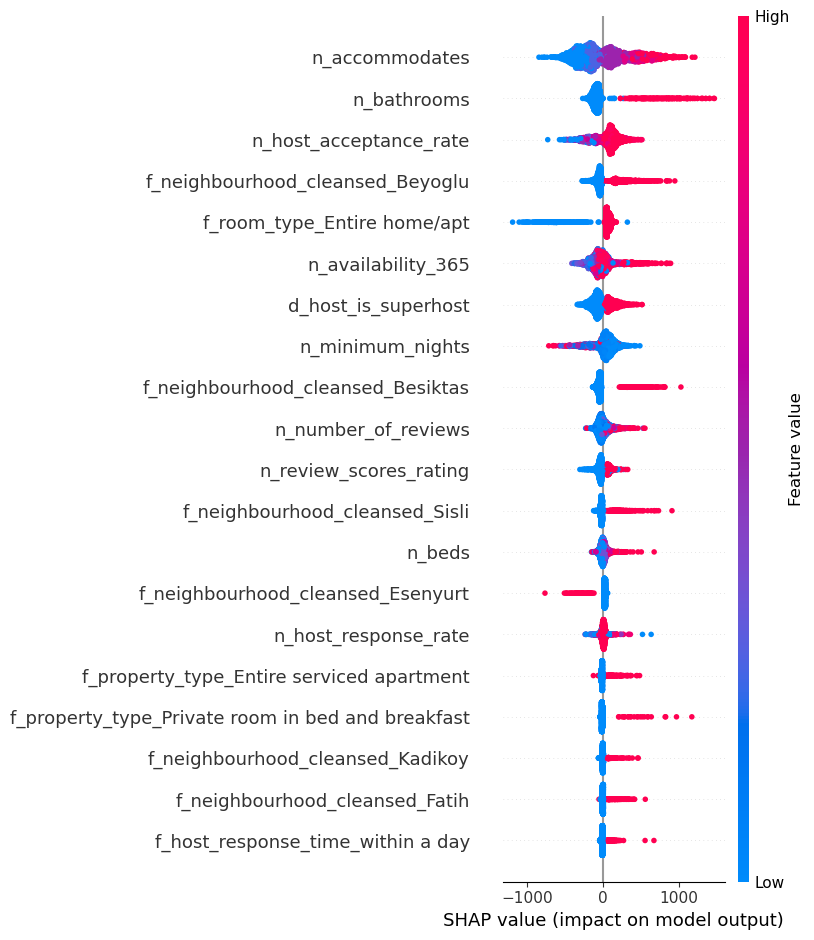

In [132]:
import shap

columns_to_filter = [
    "n_accommodates",
    "n_beds",
    "f_property_type",
    "f_room_type",
    "n_bathrooms",
    "f_neighbourhood_cleansed",
    "n_availability_365", 
    "n_minimum_nights", 
    "f_host_response_time",
    "n_host_response_rate",
    "n_host_acceptance_rate",
    "n_number_of_reviews",
    "n_review_scores_rating",
    "d_host_is_superhost", 
    "price", 
    "ln_price"] 

data_for_shap = data_final[columns_to_filter].copy()

# Perform one-hot encoding for the 'category' column
data_encoded = pd.get_dummies(data_for_shap, columns=["f_property_type","f_room_type",
                                                      "f_neighbourhood_cleansed", "f_host_response_time"])


data_encoded = data_encoded.astype(int)

# Split the data into features (X) and target (y)
X_shap = data_encoded.drop(['price', 'ln_price'], axis=1)
y_shap = data_encoded['price']

# Split the data into training and test sets
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(X_shap, y_shap, test_size=0.2, random_state=42)

# Train a Random Forest model
model_shap = RandomForestRegressor(random_state=42)
model_shap.fit(X_train_shap, y_train_shap)

# Create a SHAP explainer
explainer = shap.Explainer(model_shap, X_train_shap)

# Compute SHAP values
shap_values = explainer(X_test_shap)

# Plot SHAP values
shap.summary_plot(shap_values, X_test_shap)

**Subsample performance: RMSE / mean(y)**

Test/Holdout RMSE is calculated using test data and predicted values with this data. We will compare the both cross-validated RMSE values and test RMSE values among alternative ML models.


In [73]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf_pipeline.predict(data_holdout[predictors_2])
)

In [74]:
data_holdout_w_prediction2 = data_holdout.assign(
    predicted_price=rf_pipeline2.predict(data_holdout[predictors_2])
)

In [75]:
# RMSE on holdout/test data

rf_test_rmse_level_price = np.sqrt((sum((data_holdout_w_prediction['predicted_price']-
                                         data_holdout_w_prediction['price'])**2))/len(data_holdout_w_prediction))
print("RMSE on Holdout/Test Data for Random Forest With Level Prices:", rf_test_rmse_level_price)

RMSE on Holdout/Test Data for Random Forest With Level Prices: 1035.445347572873


In [76]:
# RMSE of ln_price on holdout/test data

rf_test_rmse_log_price = np.sqrt((sum((data_holdout_w_prediction2['predicted_price']-
                                      data_holdout_w_prediction2['ln_price'])**2))/len(data_holdout_w_prediction2))
print("RMSE on Holdout/Test Data for Random Forest With Log Prices:", rf_test_rmse_log_price)

RMSE on Holdout/Test Data for Random Forest With Log Prices: 0.4378263561343563


**Creating tables of heterogeneity by various grouping factors**

In this part we can check how model performance changes for different categories of categorical variables. By creating a new grouping using a numeric variable, model performance can even be tested on these artificially produced groups.

- Apartment size: In our analysis for Istanbul, apartment sizes are between 2-6 people. If we assume apartments with 2-3 people are small apartments and  4-6 are large apartments, we can compare the model performance between these two grpups.

In [77]:
data_holdout_w_prediction['is_low_size'] = data_holdout_w_prediction.n_accommodates.map(lambda x: 'small apt' 
                                                                                        if x <= 3 else 'large apt')

In [78]:
data_holdout_w_prediction.iloc[0:5, -3:]

,ln_price,predicted_price,is_low_size
28298,7.954021,1902.889167,small apt
3199,7.942718,2847.650996,large apt
5270,7.800163,2558.428226,small apt
8728,6.978214,1609.682224,small apt
7217,7.962416,2243.762914,large apt


In [79]:
data_holdout_w_prediction.groupby('is_low_size').apply(lambda x: mean_squared_error(x.predicted_price, x.price, squared=False))

is_low_size
large apt    1219.280319
small apt     852.570418
dtype: float64

Putting it in a function with additional columns

In [80]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
    )

In [81]:
# cheaper or more expensive flats 
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [82]:
accom_subset

,rmse,mean_price,rmse_norm
is_low_size,,,
large apt,1219.28,2574.59,0.47
small apt,852.57,1714.00,0.50


Although the mean prices is lower for small size apartments, we found a higher RMSE/mean(y) for this category.

The analysis can be extended to compare room types, property types and neighbourhoods. In order not to make the analysis too long, we will only compare model performance according to apartment sizes.

##### Model2: Ordinary Least Squares Regression (OLS)

In case of OLS and LASSO, it is better to use log-transformed price data since OLS is sensitive to non-normal data unlike Random Forest. Then we can compare RMSE values for all three models where target variable is `ln(price)`. We run every model (Random Forest, OLS, LASSO and GBM) both in level and log prices.

In [83]:
from sklearn.linear_model import LinearRegression

In [84]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)
y2, X22 = dmatrices("ln_price ~ " + " + ".join(predictors_2), data_train)

ols_model = LinearRegression().fit(X,y)
ols_model2 = LinearRegression().fit(X22,y2)

y_hat = ols_model.predict(X)
y_hat2 = ols_model2.predict(X22)

In [85]:
# 1. Evaluate Model Performance
ols_rmse = mean_squared_error(y,y_hat,squared=False)
print("RMSE:", ols_rmse)

ols_rmse_log = mean_squared_error(y2,y_hat2,squared=False)
print("RMSE of log model:", ols_rmse_log)

from sklearn.metrics import r2_score
r2 = r2_score(y, y_hat)
print("R-squared:", r2)

r2_ln = r2_score(y2, y_hat2)
print("R-squared of log model:", r2_ln)

RMSE: 1098.569541565023
RMSE of log model: 0.4562726867867421
R-squared: 0.3054101373542193
R-squared of log model: 0.4263173550933068


In [86]:
# 2. Check for Assumptions
# Use statsmodels' OLS to perform diagnostic tests
import statsmodels.api as sm

ols_model_stats = sm.OLS(y, X).fit()
print(ols_model_stats.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     49.05
Date:                Sun, 11 Feb 2024   Prob (F-statistic):               0.00
Time:                        21:42:12   Log-Likelihood:                -69201.
No. Observations:                8218   AIC:                         1.386e+05
Df Residuals:                    8144   BIC:                         1.391e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [87]:
# 3. Cross-validation
# Perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(ols_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

cv_scores_log = cross_val_score(ols_model, X22, y2, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores_log = np.sqrt(-cv_scores_log)

print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Average Cross-Validation RMSE Score (level prices):", np.average(cv_rmse_scores))

print("Cross-Validation RMSE Scores For Log-Transformed Prices:", cv_rmse_scores_log)
print("Average Cross-Validation RMSE Score (log prices):", np.average(cv_rmse_scores_log))

Cross-Validation RMSE Scores: [1089.71457531 1156.44602178 1105.45116672 1107.19877846 1100.83480385]
Average Cross-Validation RMSE Score (level prices): 1111.9290692230672
Cross-Validation RMSE Scores For Log-Transformed Prices: [0.45509809 0.47102775 0.45754209 0.46397842 0.4638589 ]
Average Cross-Validation RMSE Score (log prices): 0.4623010511027399


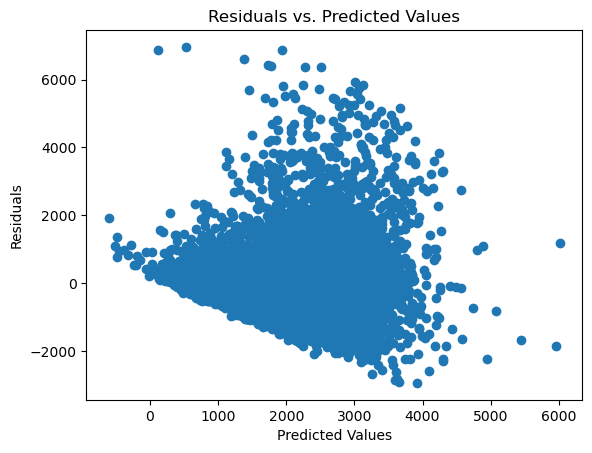

In [88]:
# 4. Visualization
# Plot residuals
residuals = y - y_hat
plt.scatter(y_hat, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()


Residuals are not homoskedastic, we should have log prices used.

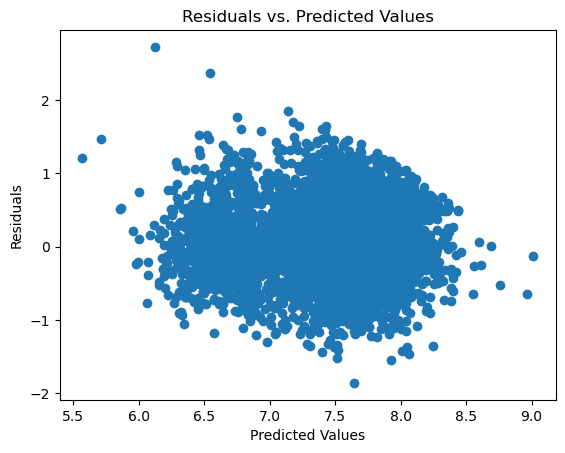

In [89]:
# Plot residuals of log transformed prices
residuals2 = y2 - y_hat2
plt.scatter(y_hat2, residuals2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

Although not perfect, heteroskedasticity seems less when we work with log transformed price data.

In [90]:
# 5. Calculate RMSE on test/holdout data

y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)
y_test2, X_test2 = dmatrices("ln_price ~ " + " + ".join(predictors_2), data_holdout)

# Predict the target variable on the test dataset
y_hat_test = ols_model.predict(X_test)
y_hat_test2 = ols_model2.predict(X_test2)


# Compute the RMSE
ols_rmse_test = mean_squared_error(y_test, y_hat_test, squared=False)
ols_rmse_test2 = mean_squared_error(y_test2, y_hat_test2, squared=False)

print("Test RMSE for OLS model:", ols_rmse_test)
print("Test RMSE for log transformed OLS model:", ols_rmse_test2)

Test RMSE for OLS model: 1078.2952367390967
Test RMSE for log transformed OLS model: 0.4573711907307754


##### Model3: LASSO Regression

In [91]:
from sklearn.linear_model import ElasticNet

In [92]:
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)
lasso_model_ln =  ElasticNet(l1_ratio = 1, fit_intercept = True)

In [93]:
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

lasso_model_cv2 = GridSearchCV(
    lasso_model_ln,
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [94]:
y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)
y2, X22 = dmatrices("ln_price ~ " + " + ".join(predictors_E), data_train)

In [95]:
%%time
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ....................alpha=0.05;, score=-1113.331 total time=   6.0s
[CV 2/5] END ....................alpha=0.05;, score=-1177.767 total time=   5.8s
[CV 3/5] END ....................alpha=0.05;, score=-1121.034 total time=   5.6s
[CV 4/5] END ....................alpha=0.05;, score=-1106.455 total time=   6.2s
[CV 5/5] END ....................alpha=0.05;, score=-1102.965 total time=   7.3s
[CV 1/5] END .....................alpha=0.1;, score=-1106.305 total time=   7.0s
[CV 2/5] END .....................alpha=0.1;, score=-1170.303 total time=   7.2s
[CV 3/5] END .....................alpha=0.1;, score=-1113.456 total time=   8.0s
[CV 4/5] END .....................alpha=0.1;, score=-1102.415 total time=   7.7s
[CV 5/5] END .....................alpha=0.1;, score=-1100.307 total time=   6.8s
[CV 1/5] END ....................alpha=0.15;, score=-1100.658 total time=   6.5s
[CV 2/5] END ....................alpha=0.15;, sco

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.05, 0.1, 0.15, 0.2, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [96]:
%%time
lasso_model_cv2.fit(X22, y2.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .......................alpha=0.05;, score=-0.502 total time=   0.6s
[CV 2/5] END .......................alpha=0.05;, score=-0.521 total time=   0.4s
[CV 3/5] END .......................alpha=0.05;, score=-0.498 total time=   0.4s
[CV 4/5] END .......................alpha=0.05;, score=-0.514 total time=   0.4s
[CV 5/5] END .......................alpha=0.05;, score=-0.513 total time=   0.3s
[CV 1/5] END ........................alpha=0.1;, score=-0.525 total time=   0.2s
[CV 2/5] END ........................alpha=0.1;, score=-0.541 total time=   0.3s
[CV 3/5] END ........................alpha=0.1;, score=-0.524 total time=   0.3s
[CV 4/5] END ........................alpha=0.1;, score=-0.536 total time=   0.2s
[CV 5/5] END ........................alpha=0.1;, score=-0.537 total time=   0.3s
[CV 1/5] END .......................alpha=0.15;, score=-0.536 total time=   0.3s
[CV 2/5] END .......................alpha=0.15;, 

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.05, 0.1, 0.15, 0.2, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [97]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
f_property_type[T.Entire condo],-294.250
f_property_type[T.Entire guest suite],-124.931
f_property_type[T.Entire guesthouse],-905.572
f_property_type[T.Entire home],136.083
f_property_type[T.Entire rental unit],-427.782
...,...
n_host_response_rate,2.048
n_host_acceptance_rate,3.867
n_number_of_reviews,-0.490
n_review_scores_rating,98.601


In [98]:
lasso_model_cv.best_estimator_

ElasticNet(alpha=0.25, l1_ratio=1)

In [99]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
print("LASSO Cross-Validated RMSE for Level Prices:", lasso_rmse)

LASSO Cross-Validated RMSE for Level Prices: 1109.665614929097


In [100]:
lasso_rmse_ln = pd.DataFrame(lasso_model_cv2.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv2.best_estimator_.alpha
].mean_test_score.values[0] * -1
print("LASSO Cross-Validated RMSE for Log Prices:", lasso_rmse_ln)

LASSO Cross-Validated RMSE for Log Prices: 0.5094302202019957


In [101]:
y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_E), data_holdout)
y_test2, X_test2 = dmatrices("ln_price ~ " + " + ".join(predictors_E), data_holdout)

# Predict the target variable on the test dataset
y_hat_test_lasso_level = lasso_model_cv.predict(X_test)
y_hat_test_lasso_log = lasso_model_cv2.predict(X_test2)

# Compute the RMSE
lasso_rmse_test_level = mean_squared_error(y_test, y_hat_test_lasso_level, squared=False)
print("Test RMSE for LASSO Model With Level Prices:", lasso_rmse_test_level)

lasso_rmse_test_log = mean_squared_error(y_test2, y_hat_test_lasso_log, squared=False)
print("Test RMSE for LASSO Model With Log Prices:", lasso_rmse_test_log)

Test RMSE for LASSO Model With Level Prices: 1069.5677137500045
Test RMSE for LASSO Model With Log Prices: 0.5046298251355317


##### Model4: Gradient Boosting Machines (GBM)

In [102]:
from sklearn.ensemble import GradientBoostingRegressor

In [103]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 10
                               )

tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [104]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [105]:
%%time
gbm_pipe.fit(data_train[predictors_2],data_train.price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  43.5s
CPU times: total: 6.45 s
Wall time: 43.6 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type',
                                                   'f_neighbourhood_cleansed',
                                                   'f_host_response_time']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_bathrooms',
                                                   'n_availability_365',
                                                   'n_minimum_nights',
                                                   'n_host_response_rate',
                                                   'n_host_acceptance_rate',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'd_host_is_superhost'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(max_features=10,
                                                                  min_samples_split=20),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10],
                                          'n_estimators': [200, 300]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [106]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(max_depth=10, max_features=10, min_samples_split=20,
                          n_estimators=300)

In [107]:
gbm_rmse = gbm_model_cv.best_score_*-1

In [108]:
gbm_rmse

1018.8071642121688

In [109]:
# Predict the target variable on the test dataset using the trained pipeline
y_hat_test_gbm = gbm_pipe.predict(data_holdout[predictors_2])

In [110]:
# Compute the test RMSE
gbm_rmse_test = mean_squared_error(data_holdout.price, y_hat_test_gbm, squared=False)
print("Test RMSE for GBM Model With Level Prices:", gbm_rmse_test)

Test RMSE for GBM Model With Level Prices: 998.5990191727085


In [111]:
%%time
gbm_pipe.fit(data_train[predictors_2],data_train.ln_price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  31.6s
CPU times: total: 4.05 s
Wall time: 31.6 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type',
                                                   'f_neighbourhood_cleansed',
                                                   'f_host_response_time']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_bathrooms',
                                                   'n_availability_365',
                                                   'n_minimum_nights',
                                                   'n_host_response_rate',
                                                   'n_host_acceptance_rate',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'd_host_is_superhost'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(max_features=10,
                                                                  min_samples_split=20),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10],
                                          'n_estimators': [200, 300]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [112]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(max_depth=10, max_features=10, min_samples_split=20,
                          n_estimators=200)

In [113]:
gbm_rmse_ln = gbm_model_cv.best_score_*-1

In [114]:
gbm_rmse_ln

0.41591711421086136

In [115]:
# Predict the target variable (log prices) on the test dataset using the trained pipeline
y_hat_test_gbm_log = gbm_pipe.predict(data_holdout[predictors_2])

In [116]:
# Compute the test RMSE for log prices
gbm_rmse_test_log = mean_squared_error(data_holdout.ln_price, y_hat_test_gbm_log, squared=False)
print("Test RMSE for GBM Model With Log Prices:", gbm_rmse_test_log)

Test RMSE for GBM Model With Log Prices: 0.40971056596748273


##### Comparison of models

In [117]:
# Compare Cross-validated RMSEs for level prices as target variable
df_cv_level_prices = pd.DataFrame({'Model': ['OLS', 'LASSO', 'Random Forest', 'GBM'],
              'CV RMSE (Level Prices)': [np.average(cv_rmse_scores), lasso_rmse, 
                                                      -rf_model2.best_score_, gbm_rmse]})

In [118]:
# Compare Cross-validated RMSEs for log transformed prices as target variable
df_cv_log_prices = pd.DataFrame({'Model': ['OLS', 'LASSO', 'Random Forest', 'GBM'],
              'CV RMSE (Log Prices)': [np.average(cv_rmse_scores_log), lasso_rmse_ln, 
                                                                -rf_model.best_score_, gbm_rmse_ln]})

In [119]:
# Compare RMSEs on test data for level prices as target variable

df_test_level_prices = pd.DataFrame({'Model': ['OLS', 'LASSO', 'Random Forest', 'GBM'],
              'Test RMSE (Level Prices)': [ols_rmse_test, lasso_rmse_test_level, rf_test_rmse_level_price, gbm_rmse_test]})

In [120]:
# Compare RMSEs on test data for log transformed prices as target variable

df_test_log_prices = pd.DataFrame({'Model': ['OLS', 'LASSO', 'Random Forest', 'GBM'],
              'Test RMSE (Log Prices)': [ols_rmse_test2, lasso_rmse_test_log, 
                                                     rf_test_rmse_log_price, gbm_rmse_test_log]})

In [121]:
# Merge dataframes
df_combined = pd.merge(df_cv_level_prices, df_test_level_prices, on='Model')
df_combined = pd.merge(df_combined, df_cv_log_prices, on='Model')
df_combined = pd.merge(df_combined, df_test_log_prices, on='Model')

In [122]:
from tabulate import tabulate

# Display the combined dataframe
print(tabulate(df_combined, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════════╤══════════════════════════╤════════════════════════════╤════════════════════════╤══════════════════════════╕
│ Model         │   CV RMSE (Level Prices) │   Test RMSE (Level Prices) │   CV RMSE (Log Prices) │   Test RMSE (Log Prices) │
╞═══════════════╪══════════════════════════╪════════════════════════════╪════════════════════════╪══════════════════════════╡
│ OLS           │                  1111.93 │                   1078.3   │               0.462301 │                 0.457371 │
├───────────────┼──────────────────────────┼────────────────────────────┼────────────────────────┼──────────────────────────┤
│ LASSO         │                  1109.67 │                   1069.57  │               0.50943  │                 0.50463  │
├───────────────┼──────────────────────────┼────────────────────────────┼────────────────────────┼──────────────────────────┤
│ Random Forest │                  1063.28 │                   1035.45  │               0.444084 │                 0.4

The best performing model in terms of cross-validated RMSEs is GBM and then Random Forest comes. OLS and LASSO have very similar RMSEs.

The next step is to compare RMSEs on holdout/test data.

GBM  is again best performing model with holdout/test data.

### Conclusion

We started our analyis with an Airbnb data for Istnabul which has many qualitative variables and a few quantitative variables. We applied EDA and Feature Engineering and used our domain knowledge to prepare estimation models. In modelling part, we started with a Random Forest model and made detailed analysis to find factors that most affect prices. Finally, we compared the base Random Forest model's overall performance with three alternative models. OLS, LASSO and GBM were our alternative models. In terms of overall performance, GBM performed best, ie, resulted with lowest RMSE both on cross-validated samples and on test sample. While room type was the most important factor in London data, number of accommodates is the most important factor in Istanbul. Second important factor in London was bathroom while in Istanbul it is room type. And third important factor in London was number of accommodates while in Istanbul it is neigbourhood. There are certain neigbourhoods both in London and Istanbul which decrease or increase the prices of accomodation.